In [82]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler

# Exploration Data

# Data Prepocessing

## Load Data

In [83]:
# Get data from Google Drive
file_id = "1WGKCLnVSzaPYtIGcSeX3bgiDvmtCsUtA"
download_url = f"https://drive.google.com/uc?id={file_id}"
df = pd.read_csv(download_url, low_memory=False)

In [84]:
# Inisial data preprocessing
clinic_data = df.loc[:, df.columns[:31]]
genomic_data = df.loc[:, df.columns[31:]]

## Handling Missing Values

### Check Missing Value

In [85]:
def missing_summary(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (total / len(df)).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['total_null', 'percent_null'])

missing_genomic = missing_summary(genomic_data)
missing_clinic = missing_summary(clinic_data)

print("Genomic Data:")
print(missing_genomic.head())

print("\nClinic Data:")
print(missing_clinic.head(14))

Genomic Data:
         total_null  percent_null
brca1             0           0.0
bche              0           0.0
cdkn2c            0           0.0
cyb5a             0           0.0
cyp11a1           0           0.0

Clinic Data:
                                total_null  percent_null
tumor_stage                            501      0.263130
3-gene_classifier_subtype              204      0.107143
primary_tumor_laterality               106      0.055672
neoplasm_histologic_grade               72      0.037815
cellularity                             54      0.028361
mutation_count                          45      0.023634
er_status_measured_by_ihc               30      0.015756
type_of_breast_surgery                  22      0.011555
tumor_size                              20      0.010504
cancer_type_detailed                    15      0.007878
tumor_other_histologic_subtype          15      0.007878
oncotree_code                           15      0.007878
death_from_cancer          

### Filling Missing Values

In [86]:
# Fill missing values in the first 13 columns of clinic data with mode
for column in missing_clinic.index[:13]:
    df[column] = df[column].fillna(df[column].mode()[0])

## Encoding

### Encoding Ordinal

In [87]:
ordinal_df = df[['cellularity','cancer_type_detailed','type_of_breast_surgery',
                       'her2_status_measured_by_snp6','pam50_+_claudin-low_subtype',
                       'her2_status_measured_by_snp6','tumor_other_histologic_subtype',
                       'integrative_cluster','3-gene_classifier_subtype','death_from_cancer']]
ordinal_df.head()

,cellularity,cancer_type_detailed,type_of_breast_surgery,her2_status_measured_by_snp6,pam50_+_claudin-low_subtype,her2_status_measured_by_snp6,tumor_other_histologic_subtype,integrative_cluster,3-gene_classifier_subtype,death_from_cancer
0,High,Breast Invasive Ductal Carcinoma,MASTECTOMY,NEUTRAL,claudin-low,NEUTRAL,Ductal/NST,4ER+,ER-/HER2-,Living
1,High,Breast Invasive Ductal Carcinoma,BREAST CONSERVING,NEUTRAL,LumA,NEUTRAL,Ductal/NST,4ER+,ER+/HER2- High Prolif,Living
2,High,Breast Invasive Ductal Carcinoma,MASTECTOMY,NEUTRAL,LumB,NEUTRAL,Ductal/NST,3,ER+/HER2- Low Prolif,Died of Disease
3,Moderate,Breast Mixed Ductal and Lobular Carcinoma,MASTECTOMY,NEUTRAL,LumB,NEUTRAL,Mixed,9,ER+/HER2- Low Prolif,Living
4,High,Breast Mixed Ductal and Lobular Carcinoma,MASTECTOMY,NEUTRAL,LumB,NEUTRAL,Mixed,9,ER+/HER2- High Prolif,Died of Disease


In [88]:
ordinal_df = ordinal_df.apply(LabelEncoder().fit_transform)
ordinal_df.head()

,cellularity,cancer_type_detailed,type_of_breast_surgery,her2_status_measured_by_snp6,pam50_+_claudin-low_subtype,her2_status_measured_by_snp6,tumor_other_histologic_subtype,integrative_cluster,3-gene_classifier_subtype,death_from_cancer
0,0,1,1,2,6,2,0,4,2,2
1,0,1,0,2,2,2,0,4,0,2
2,0,1,1,2,3,2,0,3,1,0
3,2,4,1,2,3,2,4,10,1,2
4,0,4,1,2,3,2,4,10,0,0


### Encoding Nominal

In [89]:
nominal_df = df[['er_status_measured_by_ihc','er_status', 'her2_status', 'inferred_menopausal_state',
                'primary_tumor_laterality', 'pr_status', 'oncotree_code']]
nominal_df.head()

,er_status_measured_by_ihc,er_status,her2_status,inferred_menopausal_state,primary_tumor_laterality,pr_status,oncotree_code
0,Positve,Positive,Negative,Post,Right,Negative,IDC
1,Positve,Positive,Negative,Pre,Right,Positive,IDC
2,Positve,Positive,Negative,Pre,Right,Positive,IDC
3,Positve,Positive,Negative,Pre,Right,Positive,MDLC
4,Positve,Positive,Negative,Post,Right,Positive,MDLC


In [90]:
nominal_df = pd.get_dummies(data=nominal_df, drop_first=True, dtype=int)
nominal_df.head()

,er_status_measured_by_ihc_Positve,er_status_Positive,her2_status_Positive,inferred_menopausal_state_Pre,primary_tumor_laterality_Right,pr_status_Positive,oncotree_code_IDC,oncotree_code_ILC,oncotree_code_IMMC,oncotree_code_MBC,oncotree_code_MDLC
0,1,1,0,0,1,0,1,0,0,0,0
1,1,1,0,1,1,1,1,0,0,0,0
2,1,1,0,1,1,1,1,0,0,0,0
3,1,1,0,1,1,1,0,0,0,0,1
4,1,1,0,0,1,1,0,0,0,0,1


In [91]:
treatments = ['chemotherapy', 'hormone_therapy', 'radio_therapy']
died = new_df[new_df['overall_survival']==0]
survived = new_df[new_df['overall_survival']==1]

In [92]:
genomic_data = new_df.select_dtypes(include=['object'])
genomic_data.head()
genomic_col = genomic_data.columns
for col in genomic_col:
    new_df.loc[new_df[col] != '0', col] = 1
    new_df.loc[new_df[col] == '0', col] = 0
new_df.head()
new_df[genomic_col].astype('int64')

,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1900,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1901,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1902,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


### Join Data

In [93]:
## Add Ordinal and Nominal Data to the Original DataFrame
df.drop(ordinal_df.columns, axis = 1, inplace = True)
df = df.join(ordinal_df)
df.head()
df.drop(['er_status_measured_by_ihc','er_status', 'her2_status', 'inferred_menopausal_state',
                'primary_tumor_laterality', 'pr_status', 'oncotree_code'], axis = 1, inplace = True)
df = df.join(nominal_df)
df.head()

,patient_id,age_at_diagnosis,cancer_type,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,...,er_status_Positive,her2_status_Positive,inferred_menopausal_state_Pre,primary_tumor_laterality_Right,pr_status_Positive,oncotree_code_IDC,oncotree_code_ILC,oncotree_code_IMMC,oncotree_code_MBC,oncotree_code_MDLC
0,0,75.65,Breast Cancer,0,1.0,3.0,1,10.0,5.0,6.044,...,1,0,0,1,0,1,0,0,0,0
1,2,43.19,Breast Cancer,0,1.0,3.0,1,0.0,2.0,4.020,...,1,0,1,1,1,1,0,0,0,0
2,5,48.87,Breast Cancer,1,1.0,2.0,1,1.0,2.0,4.030,...,1,0,1,1,1,1,0,0,0,0
3,6,47.68,Breast Cancer,1,1.0,2.0,1,3.0,1.0,4.050,...,1,0,1,1,1,0,0,0,0,1
4,8,76.97,Breast Cancer,1,1.0,3.0,1,8.0,2.0,6.080,...,1,0,0,1,1,0,0,0,0,1


## Rounding Age of Patients

In [94]:
## Rounding the age_at_diagnosis and nottingham_prognostic_index columns
df[['age_at_diagnosis','nottingham_prognostic_index']] = df[['age_at_diagnosis','nottingham_prognostic_index']].apply(np.ceil)

## Drop some Columns

In [95]:
# Drop because the value is same for all rows
df['cancer_type'].value_counts()
df.drop(['patient_id','cancer_type'], axis=1, inplace=True)
df.head()

,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,...,er_status_Positive,her2_status_Positive,inferred_menopausal_state_Pre,primary_tumor_laterality_Right,pr_status_Positive,oncotree_code_IDC,oncotree_code_ILC,oncotree_code_IMMC,oncotree_code_MBC,oncotree_code_MDLC
0,76.0,0,1.0,3.0,1,10.0,5.0,7.0,140.500000,1,...,1,0,0,1,0,1,0,0,0,0
1,44.0,0,1.0,3.0,1,0.0,2.0,5.0,84.633333,1,...,1,0,1,1,1,1,0,0,0,0
2,49.0,1,1.0,2.0,1,1.0,2.0,5.0,163.700000,0,...,1,0,1,1,1,1,0,0,0,0
3,48.0,1,1.0,2.0,1,3.0,1.0,5.0,164.933333,1,...,1,0,1,1,1,0,0,0,0,1
4,77.0,1,1.0,3.0,1,8.0,2.0,7.0,41.366667,0,...,1,0,0,1,1,0,0,0,0,1


In [96]:
new_clinic_data = df[df.columns[:25]]
new_clinic_data.head()
new_df = df.drop(new_clinic_data.columns, axis = 1, inplace = False)
new_df = new_df.join(new_clinic_data)
new_df.isnull().sum().sum()

np.int64(0)

In [97]:
genomic_data = new_df.select_dtypes(include=['object'])
genomic_data.head()
genomic_col = genomic_data.columns
for col in genomic_col:
    new_df.loc[new_df[col] != '0', col] = 1
    new_df.loc[new_df[col] == '0', col] = 0
new_df.head()
new_df[genomic_col].astype('int64')

,pik3ca_mut,tp53_mut,muc16_mut,ahnak2_mut,kmt2c_mut,syne1_mut,gata3_mut,map3k1_mut,ahnak_mut,dnah11_mut,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,1,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1900,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1901,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1902,0,0,0,1,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


## MinMax Scaler

In [98]:
x = new_df.loc[:, new_df.columns != 'death_from_cancer'].values
x = MinMaxScaler().fit_transform(x) # normalizing the features
x

array([[0.61181439, 0.1136925 , 0.25264315, ..., 0.23075914, 0.33257904,
        0.29369242],
       [0.78762253, 0.24314775, 0.44803561, ..., 0.03965148, 0.45158844,
        0.53923931],
       [0.47755903, 0.44333814, 0.49864671, ..., 0.20094674, 0.4167225 ,
        0.44299551],
       ...,
       [0.76387662, 0.23789921, 0.57982323, ..., 0.29688867, 0.21000468,
        0.45110639],
       [0.76805861, 0.24630373, 0.49291635, ..., 0.11171725, 0.42702552,
        0.42688401],
       [0.71995027, 0.21721382, 0.5189144 , ..., 0.26299851, 0.45534303,
        0.40985904]])

In [99]:
normalised_df = pd.DataFrame(x)
normalised_df.head()

,0,1,2,3,4,5,6,7,8,9,...,685,686,687,688,689,690,691,692,693,694
0,0.611814,0.113692,0.252643,0.314097,0.196693,0.340103,0.227145,0.598489,0.399801,0.215459,...,0.307003,0.803884,0.418195,0.617925,0.546577,0.389558,0.314940,0.230759,0.332579,0.293692
1,0.787623,0.243148,0.448036,0.436775,0.298899,0.372600,0.214084,0.482847,0.160008,0.411453,...,0.352149,0.703436,0.364437,0.415257,0.762149,0.482198,0.467018,0.039651,0.451588,0.539239
2,0.477559,0.443338,0.498647,0.609902,0.517687,0.419937,0.201976,0.565726,0.675340,0.392732,...,0.510689,0.609585,0.442372,0.441792,0.726410,0.429977,0.362737,0.200947,0.416723,0.442996
3,0.518711,0.596360,0.435285,0.645417,0.688831,0.384607,0.129512,0.537359,0.694940,0.270966,...,0.302836,0.715116,0.613203,0.326318,0.744198,0.207530,0.361148,0.257139,0.514266,0.406945
4,0.624782,0.203870,0.521262,0.395922,0.274217,0.390428,0.225039,0.306623,0.610430,0.596143,...,0.406985,0.669388,0.417900,0.508985,0.689516,0.501501,0.491916,0.292395,0.349430,0.569635


# PCA Implementation

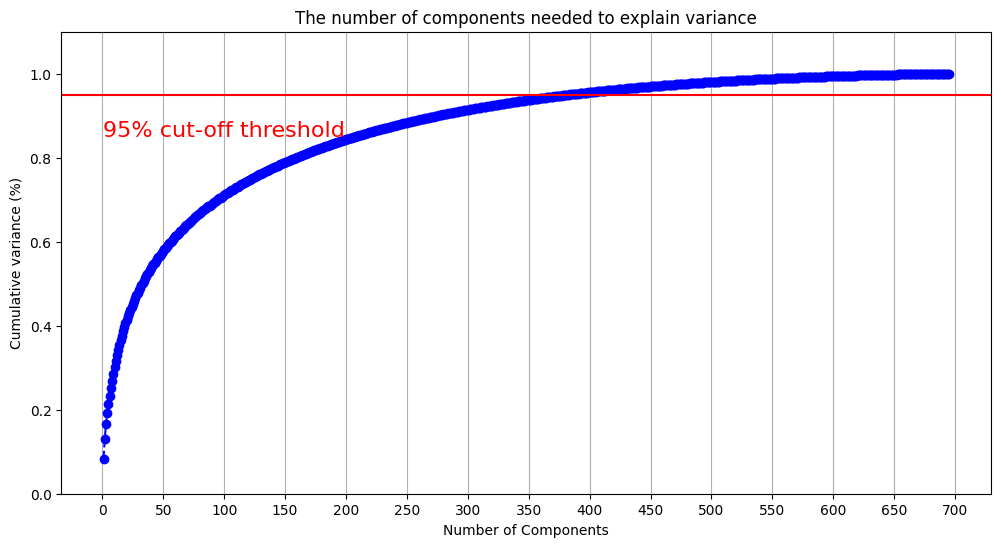

In [100]:
data_rescaled = normalised_df

pca = PCA().fit(data_rescaled)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 696, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 750, step=50)) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [101]:
pca = PCA(n_components=375)
principal_components = pca.fit_transform(data_rescaled)
principal_df = pd.DataFrame(data = principal_components)
principal_df.head()

,0,1,2,3,4,5,6,7,8,9,...,365,366,367,368,369,370,371,372,373,374
0,0.071844,1.823690,0.571922,-0.435184,-0.111845,1.177432,0.105235,0.927950,0.171567,0.907865,...,-0.243143,0.041168,0.059750,-0.027409,0.027818,-0.113482,-0.016884,-0.091457,-0.014637,0.004477
1,0.409669,0.438614,-1.094638,-0.861473,0.427827,-0.515830,-0.004465,0.273812,0.035781,0.499546,...,-0.041269,-0.075863,0.036340,0.050074,0.094724,0.067032,0.008349,-0.042660,-0.058722,0.078409
2,0.328145,1.755208,-0.734341,1.153959,0.079975,-1.452518,-0.973652,0.496443,-0.716789,0.542663,...,-0.040863,0.116172,0.006722,-0.104516,-0.097735,-0.022715,-0.004661,0.022004,0.034650,-0.006642
3,0.440305,1.767886,-0.632885,0.214213,-0.008181,-0.939153,-2.037070,-0.030058,0.334784,0.639183,...,-0.025608,-0.039605,0.038983,0.039296,-0.067777,0.101883,0.087568,0.010874,-0.179963,0.106753
4,-0.042537,0.280770,-1.329315,0.311082,-0.351498,0.722132,-0.634541,-1.198320,-0.125452,0.862902,...,-0.033148,-0.102228,0.132052,0.001593,0.006065,0.108348,-0.151899,0.042330,-0.029627,-0.074863


# Model

In [102]:
X = principal_df
y = new_df['death_from_cancer']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:


def hyper_tuning(name, model, model_params, X_train, y_train, X_test, y_test, cv):  
    grid_cv = GridSearchCV(model, model_params, n_jobs=-1, cv=cv)
    grid_cv_model = grid_cv.fit(X_train, y_train)
    print()
    print(name)
    print('Best Parameters: ', grid_cv_model.best_params_)
    print('Best Model Score = {}'.format(grid_cv_model.best_score_))
    print()
    return grid_cv_model
    
def model_metrics(model, X_train, y_train, X_test, y_test):   
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(model, X_train, y_train, cv = kfold)
    print("CV scores: ", results); print("CV Standard Deviation: ", results.std()); 
    print();
    print('CV Mean score: ', results.mean()); 
    model.fit(X_train, y_train)
    print('Train score:   ', model.score(X_train, y_train))
    print('Test score:    ', model.score(X_test, y_test))
    
    pred = model.predict(X_test)
    print()
    print('Confusion Matrix: ')
    print(confusion_matrix(y_test, pred))
    print()
    print('Classification Report:  ')
    print(classification_report(y_test, pred))
    train_score =  model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    test_pred = model.predict(X_test)
    print()
    return results.mean(), results.std()

In [104]:
BOLD = '\033[1m'
END = '\033[0m'

results = []
names = []

### KNN ###
knn_params = {
    "n_neighbors": [5, 15, 25, 30, 35, 40, 100],
    "weights": ["uniform", "distance"]
}
knn_name = BOLD + 'K Neighbors Classifier Model:' + END
knn_model = KNeighborsClassifier()
knn_best = hyper_tuning(knn_name, knn_model, knn_params, X_train, y_train, X_test, y_test, 4)
joblib.dump(knn_best, 'knn_model.pkl')
mean, std = model_metrics(knn_best, X_train, y_train, X_test, y_test)
names.append(knn_name)
results.append([std, mean, std])

### Logistic Regression ###
lr_params = {
    "penalty": ["l1", "l2"],
    "C": np.logspace(-2, 4, 10)
}
lr_name = BOLD + 'Logistic Regression Model:' + END
lr_model = LogisticRegression(solver='liblinear', random_state=42, max_iter=2000)
lr_best = hyper_tuning(lr_name, lr_model, lr_params, X_train, y_train, X_test, y_test, 4)
joblib.dump(lr_best, 'logistic_model.pkl')
mean, std = model_metrics(lr_best, X_train, y_train, X_test, y_test)
names.append(lr_name)
results.append([std, mean, std])

### Random Forest ###
rf_params = {
    'max_features': [2, 3, 5, 7, 8]
}
rf_name = BOLD + 'Random Forest Classifier Model:' + END
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_best = hyper_tuning(rf_name, rf_model, rf_params, X_train, y_train, X_test, y_test, 5)
joblib.dump(rf_best, 'random_forest_model.pkl')
mean, std = model_metrics(rf_best, X_train, y_train, X_test, y_test)
names.append(rf_name)
results.append([std, mean, std])

### Decision Tree ###
dt_params = {
    'max_depth': [1, 2, 3, 4, 5, 8]
}
dt_name = BOLD + 'Decision Tree Classifier Model:' + END
dt_model = DecisionTreeClassifier(random_state=42)
dt_best = hyper_tuning(dt_name, dt_model, dt_params, X_train, y_train, X_test, y_test, 4)
joblib.dump(dt_best, 'decision_tree_model.pkl')
mean, std = model_metrics(dt_best, X_train, y_train, X_test, y_test)
names.append(dt_name)
results.append([std, mean, std])

### Extra Trees ###
et_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [1, 2, 3, 4, 5, 8]
}
et_name = BOLD + 'Extra Trees Classifier Model:' + END
et_model = ExtraTreesClassifier(random_state=42)
et_best = hyper_tuning(et_name, et_model, et_params, X_train, y_train, X_test, y_test, 5)
joblib.dump(et_best, 'extra_trees_model.pkl')
mean, std = model_metrics(et_best, X_train, y_train, X_test, y_test)
names.append(et_name)
results.append([std, mean, std])

### AdaBoost  ###
ada_params = {
    'n_estimators': [10, 50, 100],
    'learning_rate': [0.25, 0.50]
}
ada_name = BOLD + 'AdaBoost Classifier Model:' + END
ada_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=8),  
    algorithm='SAMME', 
    random_state=42
)
ada_best = hyper_tuning(ada_name, ada_model, ada_params, X_train, y_train, X_test, y_test, 4)
joblib.dump(ada_best, 'adaboost_model.pkl')
mean, std = model_metrics(ada_best, X_train, y_train, X_test, y_test)
names.append(ada_name)
results.append([std, mean, std])




K Neighbors Classifier Model:
Best Parameters:  {'n_neighbors': 40, 'weights': 'distance'}
Best Model Score = 0.7156841414560022

CV scores:  [0.72459016 0.70491803 0.6852459  0.67105263 0.75657895]
CV Standard Deviation:  0.030087754728133038

CV Mean score:  0.7084771354616048
Train score:    1.0
Test score:     0.7034120734908137

Confusion Matrix: 
[[ 71  30  19]
 [ 42  39  13]
 [  6   3 158]]

Classification Report:  
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       120
           1       0.54      0.41      0.47        94
           2       0.83      0.95      0.89       167

    accuracy                           0.70       381
   macro avg       0.66      0.65      0.65       381
weighted avg       0.69      0.70      0.69       381



Logistic Regression Model:
Best Parameters:  {'C': np.float64(0.21544346900318834), 'penalty': 'l2'}
Best Model Score = 0.8240278353363724

CV scores:  [0.81639344 0.80983607 0.8        0.8

# Evaluation